# Q6: Activation Function

In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as py


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#  Generate data for network    #
#################################
def gen_gmm_data(n = 999):
    np.random.seed(12345)
    x=np.random.normal(size=n)
    y=np.sin(x)
    return x,y

X, Y = gen_gmm_data()



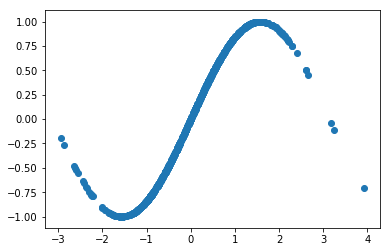

In [17]:
py.scatter(X,Y)
py.show()

In [25]:
ReLU = np.vectorize(lambda z: np.fmax(0,z))
sigmoid = lambda z: 1 / (1 + np.exp(-z))
softmax = lambda z: np.exp(z)/(np.sum(np.exp(z),axis=1))[:,np.newaxis]

# %%%%%%%%%%%%%%%%%%%%%
#  Utility Functions  #
# #####################
def predict(Y_hat):
    return np.argmax(Y_hat, axis=1)


def error_rate(Y_hat, cl):
    prediction = predict(Y_hat)
    return np.mean(prediction != cl)


def cost(Y_hat, Y):
    tot = Y * np.log(Y_hat)
    return -tot.sum()

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   1- Hidden Layer Sigmoid Network   #
####################################
def forward(X,parameters, drop_out = 1):
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    
    # Forward pass
    a1 = X.dot(W) + b1
    #H = ReLU(a1) * drop_out
    H = sigmoid(a1) * drop_out
    a2 = H.dot(V) + b2
    H2 = sigmoid(a2)*drop_out
    Y_hat = softmax(H2)
    return H,Y_hat

#%%%%%%%%%%%%%%%
#   Gradient   #
################

def grad(X,H,Y,Y_hat,parameters):  
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    # Gradients - ReLU
    dV = H.T.dot(Y_hat - Y)
    db2 = (Y_hat - Y).sum(axis=0)
    
    #dW = X.T.dot(((Y_hat - Y).dot(V.T) * (H > 0))) 
    #db1 = ((Y_hat - Y).dot(V.T) * (H > 0)).sum(axis=0)
    
    # Gradients - sigmoid
    dW = X.T.dot((Y_hat-Y).dot(V.T) * (H * (1 - H)))
    db1 = (Y_hat-Y).dot(V.T) * (H * (1 - H)).sum(axis=0)
    
    
    #return {'dV':dV,'db2':db2,'dW':dW,'db1':db1}
    return dW,db1,dV,db2

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Parameter Update: Momentum + Regularization   #
###################################################
def parameter_update(parameters,  grads, 
                     momentum_params = [0,0,0,0], 
                     lr = 1, reg = 0, alpha = 0):
    # Unpacking parameters            
    W,b1,V,b2 = parameters
    dW,db1,dV,db2 = grads
    vW,vb1,vV,vb2 = momentum_params
    
    # Momentum update
    vW  = alpha * vW -  lr * (dW + reg*W)
    vb1 = alpha * vb1 - lr * (db1 + reg*b1)
    vV  = alpha * vV -  lr * (dV + reg*V)
    vb2 = alpha * vb2 - lr * (db2 + reg*b2)
    momentum_params = [vW,vb1,vV,vb2] 
    
    # Parameter updates
    W  = W  + vW
    b1 = b1 + vb1
    V  = V  + vV
    b2 = b2 + vb2
    parameters =[W,b1,V,b2]

             
    return parameters, momentum_params

In [26]:
def run_model(X, Y,
              nodes_in_hidden_layer = 3,
              num_dim = 1,     # <- number of dimensions here it is 2: x1,x2
              num_classes = 1, # <- number of classes in the problem
              iterations = 1000,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False):    

    
    ###################################
    #   Initial values for network    #
    ###################################
    # Intialize weights
    np.random.seed(123)
    W = np.random.randn(num_dim * nodes_in_hidden_layer).reshape(num_dim,nodes_in_hidden_layer)
    b1 = 0
    V = np.random.randn(num_classes * nodes_in_hidden_layer).reshape(nodes_in_hidden_layer,num_classes)
    b2 = 0
    parameters = [W,b1,V,b2]
    
    
    # Hyperparameters 
    lr = 0.0001 # learning rate
    reg = 0.01 * regularization_include
    
    # Momentum parameters
    alpha = 0.9 * momentum_include
    vV = 0
    vb2 = 0
    vW = 0
    vb1 = 0
    momentum_params = [vW,vb1,vV,vb2]    
    
    # Place holder for losses
    losses = []
    errors = []    
   
    ###################
    #   Run the model #
    ###################
    for i in range(0,iterations):
        # -- Drop Out Mask --
        # When !=1 then ddrop rate is 12.5%  (~0.5/4 = 12.5%)
        # Short cut to include drop_out 
        drop_out =  (1 - drop_out_include) + drop_out_include * np.round(1-np.random.rand(nodes_in_hidden_layer)/4) 
        
        # -- Forward propoagation --
        H,Y_hat = forward(X,parameters,drop_out)
        
        # -- Backward propagation --
        # Gradient calculation
        grads_in = grad(X,H,Y,Y_hat,parameters)
        # Parameter update
        new_params, new_mom_param = parameter_update(parameters, grads_in, 
                             momentum_params, alpha = alpha, 
                             lr = lr, reg = reg)
        
        # -- Updating values --
        H,Y_hat = forward(X,new_params, drop_out)
        parameters = new_params
        momentum_params = new_mom_param
        
    return {"errors":errs_i, "loss":losses, "parameters":parameters}

vanilla_sgd = run_model(X,Y, iterations = 100,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False)
              

ValueError: shapes (999,) and (1,3) not aligned: 999 (dim 0) != 1 (dim 0)